In [1]:
# Change the number of cores in this code block
# by setting `spark.master` to `local[n]` where
# n is the number of cores
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

import matplotlib.pyplot as plt

conf = pyspark.SparkConf().setAll([('spark.master', 'local[4]'),
                                   ('spark.app.name', 'Data Prep')])
spark = SparkSession.builder.config(conf=conf).getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2022-05-21 03:30:46,498 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Read in data  

In [2]:
ratings_df = spark.read.csv("file:///home/work/data/ratings.csv", inferSchema=True, header=True)
ratings_df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



In [3]:
movies_df = spark.read.csv("file:///home/work/data/final_movies_df_10.csv", inferSchema=True, header=True)
movies_df.printSchema()
print(f"Total distinct movies: {movies_df.count()}")

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- avg_rating: double (nullable = true)
 |-- movieYear: integer (nullable = true)
 |-- genres: string (nullable = true)
 |-- Crime: double (nullable = true)
 |-- Romance: double (nullable = true)
 |-- Thriller: double (nullable = true)
 |-- Adventure: double (nullable = true)
 |-- Drama: double (nullable = true)
 |-- War: double (nullable = true)
 |-- Documentary: double (nullable = true)
 |-- Fantasy: double (nullable = true)
 |-- Mystery: double (nullable = true)
 |-- Musical: double (nullable = true)
 |-- Animation: double (nullable = true)
 |-- Film-Noir: double (nullable = true)
 |-- Horror: double (nullable = true)
 |-- Western: double (nullable = true)
 |-- Comedy: double (nullable = true)
 |-- Children: double (nullable = true)
 |-- Action: double (nullable = true)
 |-- Sci-Fi: double (nullable = true)

Total distinct movies: 24009


## Drop movies  

In [4]:
movies_df.createOrReplaceTempView("m")
ratings_df.createOrReplaceTempView("r")

In [5]:
tot_r = ratings_df.count()
ratings_df = spark.sql("SELECT r.userId, r.movieId, r.rating, r.timestamp FROM r JOIN m ON r.movieId == m.movieId")
tot_g = ratings_df.count()
percent_lost = (((tot_r - tot_g) / tot_r) * 100)
print(f"Total distinct movies with reviews: {ratings_df.select(col('movieId')).distinct().count()}")
print(f"Total Reviews: {tot_r} Total reviews without genres: {tot_g} Total reviews after dropping: {tot_r - tot_g}")
print(f"If drop ratings for movies without genres, we will lose {percent_lost:.3f}% of ratings data.")

Total distinct movies with reviews: 24009
Total Reviews: 25000095 Total reviews without genres: 24873798 Total reviews after dropping: 126297
If drop ratings for movies without genres, we will lose 0.505% of ratings data.


## Timestamps

In [6]:
ratings_df = ratings_df.withColumn('date',from_unixtime(col("timestamp"))).withColumn('year',year("date"))
spark.sql("drop view r");
ratings_df.createOrReplaceTempView("r")

In [7]:
ratings_df.show()

+------+-------+------+----------+-------------------+----+
|userId|movieId|rating| timestamp|               date|year|
+------+-------+------+----------+-------------------+----+
|     1|    296|   5.0|1147880044|2006-05-17 15:34:04|2006|
|     1|    306|   3.5|1147868817|2006-05-17 12:26:57|2006|
|     1|    307|   5.0|1147868828|2006-05-17 12:27:08|2006|
|     1|    665|   5.0|1147878820|2006-05-17 15:13:40|2006|
|     1|    899|   3.5|1147868510|2006-05-17 12:21:50|2006|
|     1|   1088|   4.0|1147868495|2006-05-17 12:21:35|2006|
|     1|   1175|   3.5|1147868826|2006-05-17 12:27:06|2006|
|     1|   1217|   3.5|1147878326|2006-05-17 15:05:26|2006|
|     1|   1237|   5.0|1147868839|2006-05-17 12:27:19|2006|
|     1|   1250|   4.0|1147868414|2006-05-17 12:20:14|2006|
|     1|   1260|   3.5|1147877857|2006-05-17 14:57:37|2006|
|     1|   1653|   4.0|1147868097|2006-05-17 12:14:57|2006|
|     1|   2011|   2.5|1147868079|2006-05-17 12:14:39|2006|
|     1|   2012|   2.5|1147868068|2006-0

### Plot year distribution

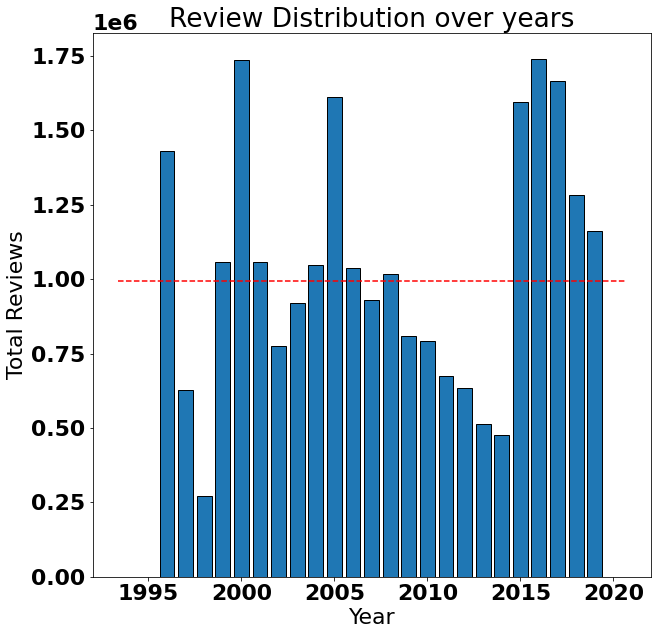

In [8]:
ratings_pd = ratings_df.groupBy("year").count().sort('count').toPandas()

font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

plt.figure(figsize=(10,10))
plt.bar(ratings_pd["year"], ratings_pd["count"],edgecolor='k')

# plot average
ax = plt.gca()
x_lims = ax.get_xlim()
plt.hlines(ratings_pd["count"].mean(), x_lims[0], x_lims[1], colors='r', linestyles='--')

plt.title("Review Distribution over years")
plt.ylabel("Total Reviews")
plt.xlabel("Year")
ax = plt.gca()
# plt.savefig('file:///home/work/data/count_review_dist.png')

Text(0.5, 0, 'Year')

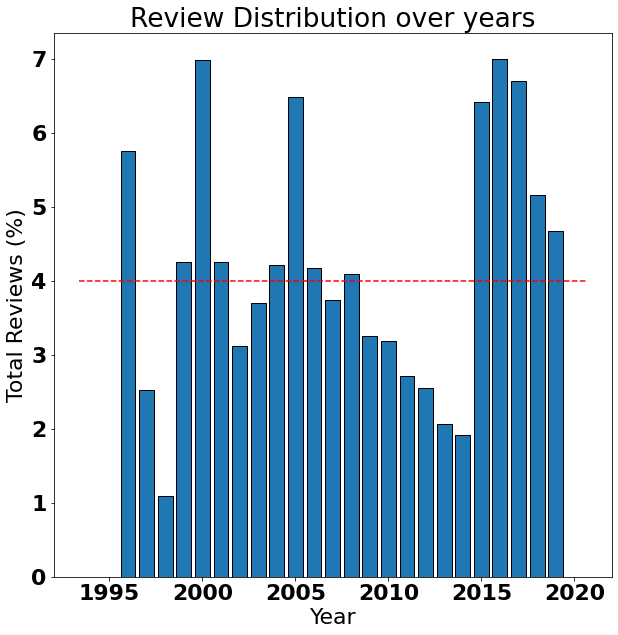

In [9]:
# Plot as percentage
ratings_pd["prop"] = (ratings_pd["count"] / ratings_pd["count"].sum()) * 100
plt.figure(figsize=(10,10))
plt.bar(ratings_pd["year"], ratings_pd["prop"],edgecolor='k')
# plot average
ax = plt.gca()
x_lims = ax.get_xlim()
plt.hlines(ratings_pd["prop"].mean(), x_lims[0], x_lims[1], colors='r', linestyles='--')

plt.title("Review Distribution over years")
plt.ylabel("Total Reviews (%)")
plt.xlabel("Year")
# plt.savefig('file:///home/work/data/percentage_review_dist.png')

## Ratings relative to first review
ie: how many users left reviews within 1 year, 2 years, 3, ...

In [10]:
#Find min timestamps for each group
min_ts_df = spark.sql("SELECT r.userId, MIN(r.timestamp) as min_ts FROM r GROUP BY r.userId ORDER BY r.userId ASC")
min_ts_df.createOrReplaceTempView("min_ts")
min_ts_df.show()

+------+----------+
|userId|    min_ts|
+------+----------+
|     1|1147868053|
|     2|1141415509|
|     3|1439472199|
|     4|1573937091|
|     5| 830786155|
|     6| 945141530|
|     7| 835444730|
|     8| 890489203|
|     9| 859381992|
|    10|1227570828|
|    11|1208038679|
|    12| 940765824|
|    13|1237969539|
|    14|1506208807|
|    15| 946011308|
|    16|1432077522|
|    17|1485581429|
|    18|1108271088|
|    19|1445258693|
|    20|1061997999|
+------+----------+
only showing top 20 rows



In [11]:
# Calculate difference
diff_df = spark.sql("SELECT r.userId, r.movieId, (r.timestamp - min_ts.min_ts) as time_diff  FROM r JOIN min_ts ON r.userId == min_ts.userId ORDER BY r.userId ASC")
diff_df = diff_df.withColumn('time_diff_years', round((col("time_diff") / (3600 * 24 * 365))))
diff_df.show()

+------+-------+---------+---------------+
|userId|movieId|time_diff|time_diff_years|
+------+-------+---------+---------------+
|     1|   2632|    10195|            0.0|
|     1|   1260|     9804|            0.0|
|     1|   2573|    10870|            0.0|
|     1|   1088|      442|            0.0|
|     1|   1250|      361|            0.0|
|     1|   2012|       15|            0.0|
|     1|   2351|     9904|            0.0|
|     1|    306|      764|            0.0|
|     1|    899|      457|            0.0|
|     1|   1217|    10273|            0.0|
|     1|   1237|      786|            0.0|
|     1|   1653|       44|            0.0|
|     1|   2011|       26|            0.0|
|     1|   2068|      991|            0.0|
|     1|   2161|      556|            0.0|
|     1|    296|    11991|            0.0|
|     1|   2843|      838|            0.0|
|     1|    307|      775|            0.0|
|     1|    665|    10767|            0.0|
|     1|   1175|      773|            0.0|
+------+---

In [12]:
# Count the occurences
diff_pd = diff_df.groupBy("time_diff_years").count().sort('count').toPandas()
diff_pd = diff_pd.rename(columns={"time_diff_years": "years"})
diff_pd = diff_pd.reset_index(drop=True)
# Add proportion
diff_pd["prop"] = (diff_pd["count"] / diff_pd["count"].sum()) * 100
diff_pd.sort_values(by=['count'], ascending=False)

,years,count,prop
22,0.0,20524280,82.513656
21,1.0,1479959,5.949871
20,2.0,794262,3.193167
19,3.0,548032,2.203250
18,4.0,391316,1.573206
17,5.0,260842,1.048662
16,6.0,199793,0.803227
15,7.0,149033,0.599157
14,8.0,117151,0.470982
13,9.0,88655,0.356419


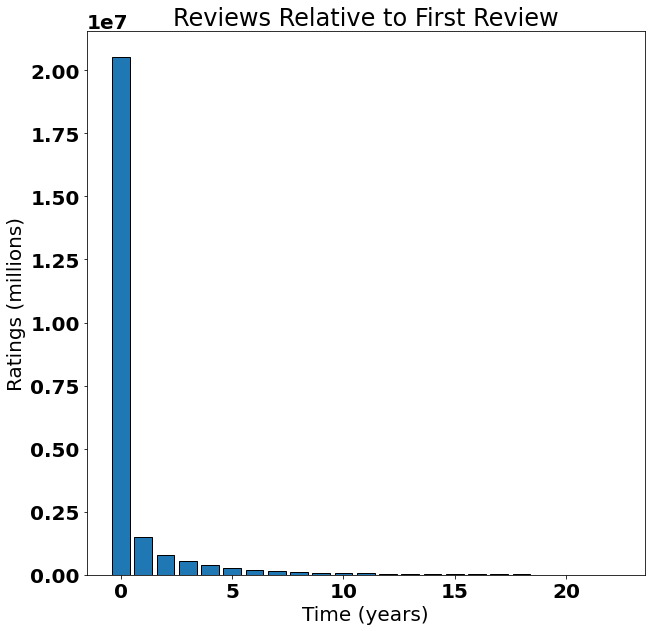

In [13]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 20}

plt.rc('font', **font)

plt.figure(figsize=(10,10))
plt.bar(diff_pd["years"], diff_pd["count"],edgecolor='k')
plt.title("Reviews Relative to First Review")
plt.ylabel("Ratings (millions)")
plt.xlabel("Time (years)")
ax = plt.gca()

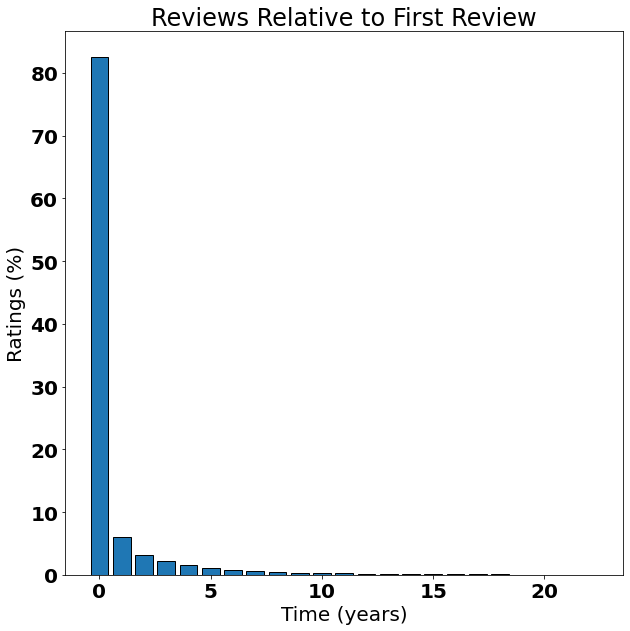

In [14]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 20}

plt.rc('font', **font)

plt.figure(figsize=(10,10))
plt.bar(diff_pd["years"], diff_pd["prop"],edgecolor='k')
plt.title("Reviews Relative to First Review")
plt.ylabel("Ratings (%)")
plt.xlabel("Time (years)")
ax = plt.gca()

In [15]:
# put together cleaned ratings
r_q = "r.userId, r.movieId, r.rating, r.year, "
movie_cols = movies_df.columns
exc_cols = ['movieId', 'title', 'genres', 'movieYear']
movie_cols = sorted(list(set(movie_cols).difference(set(exc_cols))))
m_q = ", ".join(["m.`" + c + "`" if '-' in c else "m." + c for c in movie_cols])
query = "SELECT " + r_q + m_q + " FROM r JOIN m ON r.movieId == m.movieId"
final_df = spark.sql(query)

In [16]:
# check final_df before saving
final_df.createOrReplaceTempView("f")
spark.sql("SELECT COUNT(f.movieId) FROM f").show()

+--------------+
|count(movieId)|
+--------------+
|      24873798|
+--------------+



In [17]:
final_df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- Action: double (nullable = true)
 |-- Adventure: double (nullable = true)
 |-- Animation: double (nullable = true)
 |-- Children: double (nullable = true)
 |-- Comedy: double (nullable = true)
 |-- Crime: double (nullable = true)
 |-- Documentary: double (nullable = true)
 |-- Drama: double (nullable = true)
 |-- Fantasy: double (nullable = true)
 |-- Film-Noir: double (nullable = true)
 |-- Horror: double (nullable = true)
 |-- Musical: double (nullable = true)
 |-- Mystery: double (nullable = true)
 |-- Romance: double (nullable = true)
 |-- Sci-Fi: double (nullable = true)
 |-- Thriller: double (nullable = true)
 |-- War: double (nullable = true)
 |-- Western: double (nullable = true)
 |-- avg_rating: double (nullable = true)



In [18]:
# save final_df
write_files = True
if write_files:
    final_df.coalesce(1).write.csv("hdfs:///final_df", header=True)
    !hadoop fs -ls /final_df
    !hadoop fs -copyToLocal /final_df/part-*.csv /home/work/data/

Found 2 items
-rw-r--r--   1 root supergroup          0 2022-05-21 03:34 /final_df/_SUCCESS
-rw-r--r--   1 root supergroup 2753319982 2022-05-21 03:34 /final_df/part-00000-dce47b2c-686b-4d2e-8fc2-995697b75e4a-c000.csv


In [19]:
spark.stop()